# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Собираем-сиамскую-сеть" data-toc-modified-id="Собираем-сиамскую-сеть-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Собираем сиамскую сеть</a></div><div class="lev1 toc-item"><a href="#Проверяем-глубокое-представление" data-toc-modified-id="Проверяем-глубокое-представление-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Проверяем глубокое представление</a></div>

In [17]:
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from lasagne.layers import InputLayer, DenseLayer, BatchNormLayer, Upscale2DLayer, NonlinearityLayer, ReshapeLayer
from lasagne.layers import Conv2DLayer, MaxPool2DLayer, dropout

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

In [3]:
# Seed for reproducibility
np.random.seed(42)

In [4]:
# Download the MNIST digits dataset
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2017-03-11 19:11:30--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: 'mnist.pkl.gz'

100%[======================================>] 16,168,813  4.91MB/s   in 3.3s   

2017-03-11 19:11:34 (4.67 MB/s) - 'mnist.pkl.gz' saved [16168813/16168813]



In [5]:
# Load training and test splits as numpy arrays
train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

In [15]:
X_train = X_train.reshape([-1,1,28,28])
X_val = X_val.reshape([-1,1,28,28])

# Собираем сиамскую сеть

In [32]:
input_image_left  = T.tensor4('input_left')
input_image_positive = T.tensor4('input_positive')
input_image_negative = T.tensor4('input_negative')

In [33]:
targ_var = T.dvector("target")

In [34]:
l_input = InputLayer(shape=(None, 1, 28, 28), input_var=input_image_left)
p_input = InputLayer(shape=(None, 1, 28, 28), input_var=input_image_positive)
n_input = InputLayer(shape=(None, 1, 28, 28), input_var=input_image_negative)

In [35]:
my_nonlin = rectify
nn_l_conv1 = Conv2DLayer(l_input, 32, (3, 3), nonlinearity=my_nonlin, W=lasagne.init.GlorotUniform())
nn_l_pool1 = MaxPool2DLayer(nn_l_conv1, (2, 2))
nn_l_conv2 = Conv2DLayer(nn_l_pool1, 32, (3, 3), nonlinearity=my_nonlin)
nn_l_pool2 = MaxPool2DLayer(nn_l_conv2, (2, 2))
nn_l_dense = DenseLayer(dropout(nn_l_pool2, p=.5), num_units=256, nonlinearity=my_nonlin)
nn_l_out = DenseLayer(dropout(nn_l_dense, p=.5), num_units=128, nonlinearity=my_nonlin)

In [36]:
l_params = lasagne.layers.get_all_params(nn_l_out)

In [37]:
nn_p_conv1 = Conv2DLayer(p_input, 32, (3, 3), nonlinearity=my_nonlin, W=l_params[0], b=l_params[1])
nn_p_pool1 = MaxPool2DLayer(nn_p_conv1, (2, 2))
nn_p_conv2 = Conv2DLayer(nn_p_pool1, 32, (3, 3), nonlinearity=my_nonlin, W=l_params[2], b=l_params[3])
nn_p_pool2 = MaxPool2DLayer(nn_p_conv2, (2, 2))
nn_p_dense = DenseLayer(dropout(nn_p_pool2, p=0.5), num_units=256, nonlinearity=my_nonlin, W=l_params[4], b=l_params[5])
nn_p_out = DenseLayer(dropout(nn_p_dense, p=0.5), num_units=128, nonlinearity=my_nonlin, W=l_params[6], b=l_params[7])

In [38]:
nn_n_conv1 = Conv2DLayer(n_input, 32, (3, 3), nonlinearity=my_nonlin, W=l_params[0], b=l_params[1])
nn_n_pool1 = MaxPool2DLayer(nn_n_conv1, (2, 2))
nn_n_conv2 = Conv2DLayer(nn_n_pool1, 32, (3, 3), nonlinearity=my_nonlin, W=l_params[2], b=l_params[3])
nn_n_pool2 = MaxPool2DLayer(nn_n_conv2, (2, 2))
nn_n_dense = DenseLayer(dropout(nn_n_pool2, p=0.5), num_units=256, nonlinearity=my_nonlin, W=l_params[4], b=l_params[5])
nn_n_out = DenseLayer(dropout(nn_n_dense, p=0.5), num_units=128, nonlinearity=my_nonlin, W=l_params[6], b=l_params[7])

In [39]:
nn_merge = lasagne.layers.concat([nn_l_out, nn_p_out, nn_n_out], axis=1)

In [40]:
nn_out  = lasagne.layers.get_output(nn_merge, deterministic=False)
nn_out_test  = lasagne.layers.get_output(nn_merge, deterministic=True)
nn_out_left = nn_out[:, :128]
nn_out_positive = nn_out[:, 128:256]
nn_out_negative = nn_out[:, 256:]

nn_out_left_test = nn_out_test[:, :128]
nn_out_positive_test = nn_out_test[:, 128:256]
nn_out_negative_test = nn_out_test[:, 256:]

In [41]:
a = T.scalar()

d1 = T.sum(T.sqr(nn_out_left - nn_out_positive), axis=1)
d2 = T.sum(T.sqr(nn_out_left - nn_out_negative), axis=1)

loss = T.sum(T.maximum(T.sqr(d1) - T.sqr(d2) + a, 0.))

In [42]:
d1_test = T.sum(T.sqr(nn_out_left_test - nn_out_positive_test), axis=1)
d2_test = T.sum(T.sqr(nn_out_left_test - nn_out_negative_test), axis=1)

test_loss = T.sum(T.maximum(T.sqr(d1_test) - T.sqr(d2_test) + a, 0.))
# margin = 1.2
# d = T.sum(T.sqr(nn_out_left - nn_out_right), axis=1)
# d_test = T.sum(T.sqr(nn_out_left_test - nn_out_right_test), axis=1)

# loss = T.mean(targ_var * T.sqr(d) + (1 - targ_var) * T.sqr(T.maximum(margin - d, 0)))

# mean_accuracy = T.mean(T.eq(targ_var, (d_test < margin)))

In [43]:
params = lasagne.layers.get_all_params(nn_merge)
# updates = lasagne.updates.rmsprop(loss, params)
updates = lasagne.updates.adamax(loss, params)
# updates = lasagne.updates.nesterov_momentum(loss, params, 0.01)

In [44]:
train_fn = theano.function([input_image_left, input_image_positive, input_image_negative, a], loss, 
                           updates=updates, allow_input_downcast=True)
val_fn = theano.function([input_image_left, input_image_positive, input_image_negative, a], test_loss, 
                         updates=updates, allow_input_downcast=True)
test_fn = theano.function([input_image_left, input_image_positive, input_image_negative], [d1_test, d2_test], 
                          allow_input_downcast=True)
output_fn = theano.function([input_image_left, input_image_positive, input_image_negative], nn_out, 
                            allow_input_downcast=True)

In [45]:
def iterate_minibatches(inputs, targets, batchs_per_epoch=100, batchsize=20, train=True, shuffle=False):
    assert len(inputs) == len(targets)

    left_indices = np.arange(len(inputs))
    
    if shuffle:
        np.random.shuffle(left_indices)
        
    for _ in range(batchs_per_epoch):
        full_lft_indxs = []
        full_pos_indxs = []
        full_neg_indxs = []
        
        for _ in range(batchsize):
            start_idx = np.random.randint(low=0, high=len(left_indices))
            full_lft_indxs.append(start_idx)
            
            pos_idxs = np.where(targets == targets[start_idx])[0]
            b_idxs = np.random.randint(low=0, high=len(pos_idxs), size=1)
            full_pos_indxs.append(pos_idxs[b_idxs[0]])
            
            neg_idxs = np.where(targets != targets[start_idx])[0]
            b_idxs = np.random.randint(low=0, high=len(neg_idxs), size=1)
            full_neg_indxs.append(neg_idxs[b_idxs[0]])

        full_lft_indxs = np.array(full_lft_indxs)
        full_pos_indxs = np.array(full_pos_indxs)
        full_neg_indxs = np.array(full_neg_indxs)
        
        yield inputs[full_lft_indxs], inputs[full_pos_indxs], inputs[full_neg_indxs]

In [58]:
num_epochs = 200
train_errors = []
val_errors = []
epoch = 0
batch_size = 64
batchs_per_epoch = 20

margin = 1.242

In [59]:
import time

for epoch in range(epoch, num_epochs):
    
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batchs_per_epoch=batchs_per_epoch,
                                     batchsize=batch_size, train=True, shuffle=True):
        inputs_left, inputs_positive, inputs_negative = batch
        err = train_fn(inputs_left, inputs_positive, inputs_negative, margin)
        train_err += err
        train_batches += 1
    print err

    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batchs_per_epoch=batchs_per_epoch,
                                     batchsize=batch_size, train=False, shuffle=True):
        inputs_left, inputs_positive, inputs_negative = batch
        err = val_fn(inputs_left, inputs_positive, inputs_negative, margin)
        val_err += err
        val_batches += 1

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    train_errors.append(train_err / train_batches)
    val_errors.append(val_err / val_batches)

0.559435904026
Epoch 1 of 200 took 0.892s
  training loss:		2.143881
  validation loss:		0.408856
9.64039802551
Epoch 2 of 200 took 0.844s
  training loss:		2.531889
  validation loss:		0.714284
0.0
Epoch 3 of 200 took 0.845s
  training loss:		2.898446
  validation loss:		0.472841
1.39858973026
Epoch 4 of 200 took 0.844s
  training loss:		1.916764
  validation loss:		0.385394
0.300305843353
Epoch 5 of 200 took 0.845s
  training loss:		2.733212
  validation loss:		0.346049
4.69260597229
Epoch 6 of 200 took 0.845s
  training loss:		2.894372
  validation loss:		0.559814
6.04941606522
Epoch 7 of 200 took 0.845s
  training loss:		3.182386
  validation loss:		0.526602
0.0
Epoch 8 of 200 took 0.845s
  training loss:		3.240334
  validation loss:		0.478506
0.236488580704
Epoch 9 of 200 took 0.845s
  training loss:		1.591582
  validation loss:		0.291724
0.436748802662
Epoch 10 of 200 took 0.845s
  training loss:		2.459321
  validation loss:		1.041632
0.539498448372
Epoch 11 of 200 took 0.845s
  

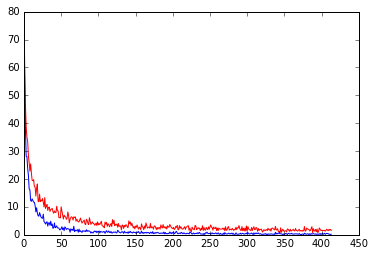

In [60]:
plt.plot(train_errors, 'r')
plt.plot(val_errors, 'b')
plt.show()

# Проверяем глубокое представление

In [68]:
from sklearn import decomposition

In [73]:
from mpl_toolkits.mplot3d import Axes3D

In [61]:
deep_ids = []

In [63]:
for i in range(X_val.shape[0]):
    deep_ids.append(output_fn([X_val[i]], [X_val[0]], [X_val[0]])[0])

In [66]:
deep_ids = np.array(deep_ids)

In [90]:
pca = decomposition.PCA(n_components=2)
pca.fit(deep_ids)

PCA(copy=True, n_components=2, whiten=False)

In [91]:
X_val_vis = pca.transform(deep_ids)

In [92]:
np.save('X_val_vis-2D', arr=X_val_vis)

In [89]:
np.save('y_val_vis', arr=y_val)

In [78]:
X_val_vis

array([[ 0.81217653,  0.62184775, -0.3798252 ],
       [-0.03250882,  0.13935599, -0.26894423],
       [-1.15822577,  0.34297687, -0.24278218],
       ..., 
       [-0.1811749 ,  0.91749823,  0.2378961 ],
       [-0.97392356,  0.22821394, -0.13266127],
       [-0.21669127,  0.31521446, -0.10273742]], dtype=float32)

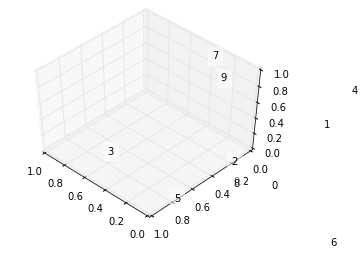

In [86]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for label in range(10):
    ax.text3D(X_val_vis[y_val == label, 0].mean(),
              X_val_vis[y_val == label, 1].mean(),
              X_val_vis[y_val == label, 2].mean(), str(label),
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    
plt.show()